In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sys import path
import matplotlib.pyplot as plt
import pymmwr as pm
from datetime import datetime
from datetime import date
from datetime import timedelta
import seaborn as sns
from matplotlib.pyplot import cm

In [2]:
"""Import locations"""

locations = pd.read_csv("./locations.csv", skiprows=0)
locations = locations.drop([0])  # skip first row (national ID)
print("Number of Locations:", len(locations))
locations.head()

Number of Locations: 52


,abbreviation,location,location_name,population,Unnamed: 4,count_rate1,count_rate2,count_rate2p5,count_rate3,count_rate4,count_rate5
1,AL,01,Alabama,5063778,NaN,51,101,127,152,203,253
2,AK,02,Alaska,711426,NaN,7,14,18,21,28,36
3,AZ,04,Arizona,7341018,NaN,73,147,184,220,294,367
4,AR,05,Arkansas,3041878,NaN,30,61,76,91,122,152
5,CA,06,California,38886551,NaN,389,778,972,1167,1555,1944


In [3]:
"""Extract hospitalization data"""

actual_data = pd.read_csv(
    "./COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv"
)
actual_data = actual_data[
    ["date", "state", "previous_day_admission_influenza_confirmed"]
].sort_values(["state", "date"])
actual_data["date"] = pd.to_datetime(actual_data["date"])
actual_data.head()

,date,state,previous_day_admission_influenza_confirmed
33828,2020-03-23,AK,NaN
28607,2020-03-24,AK,NaN
34678,2020-03-25,AK,NaN
32325,2020-03-26,AK,NaN
26758,2020-03-27,AK,NaN


In [4]:
"""Map location numbers to state abbreviations"""

location_to_state = {}
for index, row in locations.iterrows():
    location_number = row["location"]
    abbreviation = row["abbreviation"]
    location_to_state.update({location_number: abbreviation})
print(location_to_state)

{'01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}


In [5]:
"""Testing. Get a single state's actual data."""

NY_actual_data = pd.DataFrame(actual_data[actual_data["state"] == "NY"])
NY_actual_data
daily_count = NY_actual_data.loc[NY_actual_data["date"] == "2023-05-13"].values[0, 2]
daily_count

7.0

In [6]:
"""Convert the forecast data files into a dataframe"""

from os import listdir
from os.path import isfile, join

forecast_path = "./LosAlamos_NAU-CModel_Flu/"
forecast_files = [
    file for file in listdir(forecast_path) if isfile(join(forecast_path, file))
]
forecast_files.sort()

dataframes = []
for file in forecast_files:
    df = pd.read_csv(forecast_path + file)
    df["target_end_date"] = pd.to_datetime(df["target_end_date"])
    dataframes.append(df)

all_forecasts = pd.concat(dataframes)
all_forecasts

,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2023-10-21,wk inc flu hosp,-1,2023-10-14,11,quantile,0.01,0.0
1,2023-10-21,wk inc flu hosp,-1,2023-10-14,11,quantile,0.025,0.0
2,2023-10-21,wk inc flu hosp,-1,2023-10-14,11,quantile,0.05,0.0
3,2023-10-21,wk inc flu hosp,-1,2023-10-14,11,quantile,0.1,0.0
4,2023-10-21,wk inc flu hosp,-1,2023-10-14,11,quantile,0.15,0.0
...,...,...,...,...,...,...,...,...
5931,2024-04-06,wk flu hosp rate change,3,2024-04-27,US,pmf,stable,1.0
5932,2024-04-06,wk flu hosp rate change,3,2024-04-27,US,pmf,increase,0.0
5933,2024-04-06,wk flu hosp rate change,3,2024-04-27,US,pmf,large_increase,0.0
5934,2024-04-06,wk flu hosp rate change,3,2024-04-27,US,pmf,decrease,0.0


In [7]:
"""Testing. Get a single state's forecast data."""

MI_forecast_data = all_forecasts[all_forecasts["location"] == "26"]
MI_forecast_data = MI_forecast_data[MI_forecast_data["output_type"] == "quantile"]
MI_forecast_data["output_type_id"] = MI_forecast_data["output_type_id"].astype(float)
MI_forecast_data.to_csv("./mi-data-test.csv")

print(all(isinstance(x, float) for x in MI_forecast_data["value"]))

print(all(isinstance(x, float) for x in MI_forecast_data["output_type_id"]))

True
True


In [8]:
"""Define the Interval Score and Weighted Interval Score functions"""

"""https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7880475/"""


def IS(alpha, predL, predU):

    return (
        lambda y: (predU - predL)
        + 2 / alpha * (y < predL) * (predL - y)
        + 2 / alpha * (y > predU) * (y - predU)
    )


def WIS(y_obs, qtlMark, predQTL):

    is_well_defined = np.mod(len(qtlMark), 2) != 0

    NcentralizedQT = (len(qtlMark) - 1) // 2 + 1

    alpha_list = np.zeros(NcentralizedQT)
    weight_list = np.zeros(NcentralizedQT)

    for i in range(NcentralizedQT):
        is_well_defined = is_well_defined & (
            np.abs(-1.0 + qtlMark[i] + qtlMark[-1 - i]) < 1e-8
        )
        alpha_list[i] = 1 - (qtlMark[-1 - i] - qtlMark[i])
        weight_list[i] = alpha_list[i] / 2

    if is_well_defined:
        # print(alpha_list)
        # print(qtlMark)
        # print(NcentralizedQT)

        output = 1.0 / 2 * np.abs(y_obs - predQTL[NcentralizedQT - 1])

        for i in range(NcentralizedQT - 1):
            output += weight_list[i] * IS(alpha_list[i], predQTL[i], predQTL[-1 - i])(
                y_obs
            )
            # print(alpha_list[i], predQTL[i],predQTL[-1-i])

        return output / (NcentralizedQT - 1 / 2)

    else:
        print(
            "Check the quantile marks: either no median defined, or not in symmetric central QTL form."
        )

In [9]:
"""Testing to see if all states/locations are represented in our forecast data files. """

test_data = pd.read_csv(
    "./LosAlamos_NAU-CModel_Flu/2023-10-21-LosAlamos_NAU-CModel_Flu.csv"
)
unique_states = len(test_data["location"].unique())
unique_states

53

In [10]:
def get_target_dates_list(forecast_df):
    return forecast_df["target_end_date"].unique()


def get_state_hosp_data(state_code):
    state_abbrev = location_to_state[str(state_code).zfill(2)]
    return actual_data[actual_data["state"] == state_abbrev]


def one_state_one_week_WIS_scores(forecast_df, state_code):
    state_code = str(state_code).zfill(2)
    quantiles = np.zeros((23, 4))
    wis = np.zeros(4)

    state_actual_data = get_state_hosp_data(state_code)

    target_dates = get_target_dates_list(forecast_df)

    for n_week_ahead in range(4):
        target_date = target_dates[n_week_ahead]

        # Sum the daily reported cases to find the weekly observation.
        observation = 0
        for i in range(7):
            target_date = str(date.fromisoformat(target_date) + timedelta(days=-i))
            daily_count = state_actual_data.loc[
                state_actual_data["date"] == target_date
            ].values[0, 2]
            observation += daily_count

        df_state = forecast_df[forecast_df["location"].to_numpy() == state_code]
        df_state_forecast = df_state[
            df_state["target_end_date"] == target_dates[n_week_ahead]
        ]
        quantiles = df_state_forecast["output_type_id"].astype(float).to_numpy()
        predictions = df_state_forecast["value"].astype(float).to_numpy()

        try:
            wis[n_week_ahead] = np.round(
                np.sum(np.nan_to_num(WIS(observation, quantiles, predictions))), 2
            )
        except:
            # if an error occurs, print the corresponding data
            print("An error occured. Output will include a row of 0's.")
            print(df_state_forecast)
            print(quantiles)
            print(predictions)

    # Send scores to csv
    one_week_scores = {
        "state_code": state_code,
        "state_abbrev": location_to_state[state_code],
        "date": target_dates[0],
        "1wk_WIS": wis[0],
        "2wk_WIS": wis[1],
        "3wk_WIS": wis[2],
        "4wk_WIS": wis[3],
    }

    return one_week_scores


def one_state_all_scores(state_code):
    state_code = str(state_code).zfill(2)

    state_df = pd.DataFrame(columns=[])

    forecast_path = "./LosAlamos_NAU-CModel_Flu/"
    forecast_files = [
        file for file in listdir(forecast_path) if isfile(join(forecast_path, file))
    ]
    forecast_files.sort()

    for file in forecast_files:
        all_forecast_data = pd.read_csv(forecast_path + file)
        all_forecast_data = all_forecast_data[
            all_forecast_data["output_type"] == "quantile"
        ]

        weekly_scores = one_state_one_week_WIS_scores(all_forecast_data, state_code)
        state_df = pd.concat(
            [state_df, pd.DataFrame([weekly_scores])], ignore_index=True
        )

    # Export to CSV
    state_csv_path = "./mcmc_accuracy_results/" + location_to_state[state_code] + ".csv"
    state_df.to_csv(state_csv_path)

In [11]:
""" Testing """

forecast_path = "./LosAlamos_NAU-CModel_Flu/2023-10-21-LosAlamos_NAU-CModel_Flu.csv"
all_forecast_data = pd.read_csv(forecast_path)
all_forecast_data = all_forecast_data[all_forecast_data["output_type"] == "quantile"]
AZ_forecast_data = all_forecast_data[all_forecast_data["location"] == "04"]

# Check if all values are floats.
all(isinstance(x, float) for x in AZ_forecast_data["value"])

True

In [12]:
""" Testing the one state function """

one_state_one_week_WIS_scores(all_forecast_data, 4)

{'state_code': '04',
 'state_abbrev': 'AZ',
 'date': '2023-10-14',
 '1wk_WIS': 13.96,
 '2wk_WIS': 20.47,
 '3wk_WIS': 26.59,
 '4wk_WIS': 32.46}

In [13]:
one_state_all_scores("04")

In [14]:
for state in location_to_state.keys():
    one_state_all_scores(state)

Check the quantile marks: either no median defined, or not in symmetric central QTL form.
An error occured. Output will include a row of 0's.
Empty DataFrame
Columns: [reference_date, location, horizon, target, target_end_date, output_type, output_type_id, value]
Index: []
[]
[]
Check the quantile marks: either no median defined, or not in symmetric central QTL form.
An error occured. Output will include a row of 0's.
Empty DataFrame
Columns: [reference_date, location, horizon, target, target_end_date, output_type, output_type_id, value]
Index: []
[]
[]
Check the quantile marks: either no median defined, or not in symmetric central QTL form.
An error occured. Output will include a row of 0's.
Empty DataFrame
Columns: [reference_date, location, horizon, target, target_end_date, output_type, output_type_id, value]
Index: []
[]
[]
Check the quantile marks: either no median defined, or not in symmetric central QTL form.
An error occured. Output will include a row of 0's.
Empty DataFrame
Co

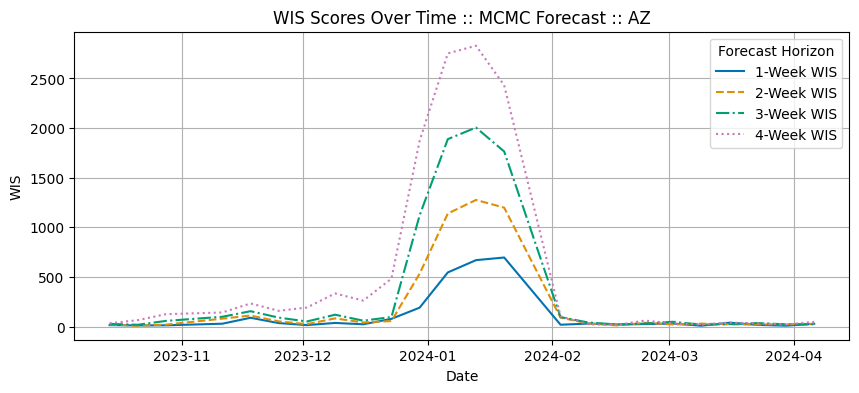

In [15]:
"""Plotting"""


def plot_one_state(state_csv):
    data = pd.read_csv(state_csv)

    data["date"] = pd.to_datetime(data["date"])
    state_name = data["state_abbrev"][1]

    palette = sns.color_palette("colorblind")

    plt.figure(figsize=(10, 4))
    sns.lineplot(
        x="date",
        y="1wk_WIS",
        data=data,
        label="1-Week WIS",
        color=palette[0],
        linestyle="-",
    )
    sns.lineplot(
        x="date",
        y="2wk_WIS",
        data=data,
        label="2-Week WIS",
        color=palette[1],
        linestyle="--",
    )
    sns.lineplot(
        x="date",
        y="3wk_WIS",
        data=data,
        label="3-Week WIS",
        color=palette[2],
        linestyle="-.",
    )
    sns.lineplot(
        x="date",
        y="4wk_WIS",
        data=data,
        label="4-Week WIS",
        color=palette[4],
        linestyle=":",
    )

    plt.title("WIS Scores Over Time :: MCMC Forecast :: " + state_name)
    plt.xlabel("Date")
    plt.ylabel("WIS")
    plt.legend(title="Forecast Horizon")
    plt.grid(True)
    plt.show()


plot_one_state("./mcmc_accuracy_results/AZ.csv")

    1wk_WIS  2wk_WIS  3wk_WIS  4wk_WIS
0     13.96    20.47    26.59    32.46
1     11.13     7.98    17.58    64.31
2     12.13    18.74    56.58   124.31
3     28.20    79.27    98.32   141.61
4     88.20   110.27   154.32   232.61
5     34.62    51.55    89.54   158.12
6     14.08    23.61    50.70   191.40
7     36.13    81.89   119.06   333.32
8     22.45    40.76    58.83   261.04
9     77.31    55.19    95.74   482.76
10   190.05   532.57  1120.86  1872.30
11   545.17  1138.66  1888.50  2752.71
12   669.00  1275.98  2005.39  2830.31
13   695.54  1198.30  1764.34  2431.39
14    17.94    89.52    94.83   102.97
15    29.82    31.02    39.63    21.69
16    20.47    11.22    21.07    16.33
17    24.63    37.07    29.43    59.78
18    29.62    20.65    47.75    30.57
19     8.17    28.78    17.44    20.23
20    38.50    21.62    24.63    39.40
21    16.47    20.90    34.37    31.74
22     8.52    22.55    21.67    20.03
23    27.35    26.82    22.13    46.69
    1wk_WIS  2wk_WIS  3wk

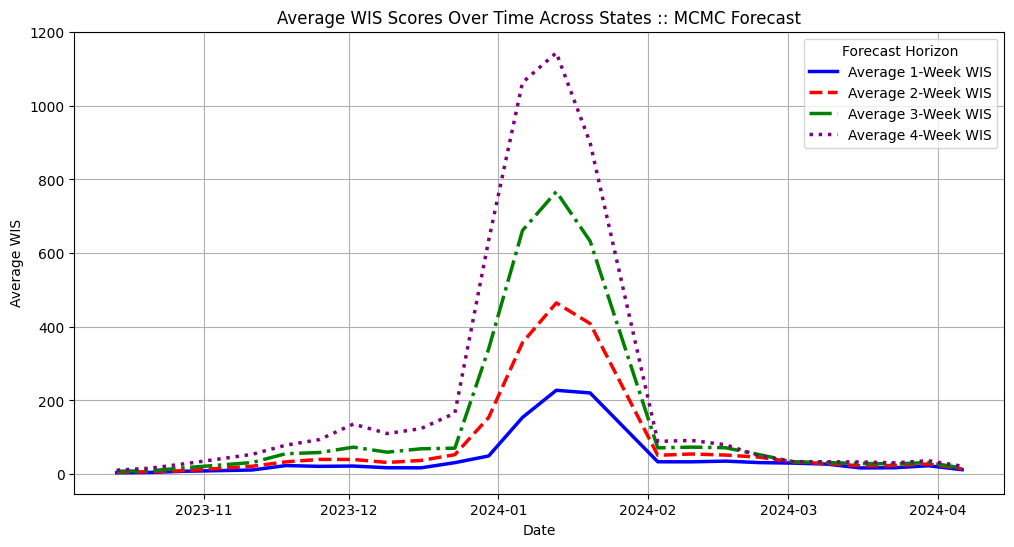

In [16]:
def one_state_one_week_WIS(forecast_df, state_code_input):
    """
    Generates one state's WIS scores for a single week's predictions.

    Args:
        forecast_df (Dataframe): Contains the forecast data.
        state_code (Int): The location code for the current state.

    Returns:
        dict: WIS scores and state info, to be converted later into a csv row.
    """
    quantiles = np.zeros((23, 4))
    reported_data = np.zeros(4)
    wis = np.zeros(4)

    state_code = str(state_code_input).zfill(2)
    state_hosp_data = get_state_hosp_data(state_code)
    target_dates = get_target_dates_list(forecast_df)

    for n_week_ahead in range(4):
        target_date = target_dates[n_week_ahead]

        """Sum the daily reported cases to find the weekly observation."""
        observation = 0
        for i in range(7):
            target_date = str(date.fromisoformat(target_date) + timedelta(days=-i))
            daily_count = state_hosp_data.loc[
                state_hosp_data["date"] == target_date
            ].values[0, 2]
            observation += daily_count

        reported_data[n_week_ahead] = observation

        df_state = forecast_df[forecast_df["location"].to_numpy() == state_code]
        df_state_forecast = df_state[
            df_state["target_end_date"] == target_dates[n_week_ahead]
        ]
        quantiles = df_state_forecast["output_type_id"].astype(float).to_numpy()
        predictions = df_state_forecast["value"].astype(float).to_numpy()

        try:
            wis[n_week_ahead] = np.round(
                np.sum(np.nan_to_num(WIS(observation, quantiles, predictions))), 2
            )
        except:
            print("An error occured. Output may include a row of 0's.")
            print("Check the", location_to_state[state_code], "data file.\n")

    """One_week_scores will be read to a csv"""
    one_week_scores = {
        "state_code": state_code,
        "state_abbrev": location_to_state[state_code],
        "date": target_dates[0],
        "1wk_WIS": wis[0],
        "2wk_WIS": wis[1],
        "3wk_WIS": wis[2],
        "4wk_WIS": wis[3],
    }

    plotting_output = [quantiles, reported_data, wis]

    return one_week_scores


def plot_average_of_all_states(data_folder_path):
    # Directory containing all the CSV files

    # List to hold data from each state
    data_list = []
    wis_columns = ["1wk_WIS", "2wk_WIS", "3wk_WIS", "4wk_WIS"]

    # Read each CSV file in the directory
    for filename in listdir(data_folder_path):
        if filename.endswith(".csv"):
            # Load the data
            file_path = join(data_folder_path, filename)
            data = pd.read_csv(file_path)

            # Convert 'date' column to datetime format
            data["date"] = pd.to_datetime(data["date"])

            print(data[wis_columns])

            for col in wis_columns:
                data[col] = pd.to_numeric(data[col], errors="coerce")

            # Check if any row has all zeros in WIS columns
            # if so, don't use it.
            if not (data[wis_columns] == 0).all(axis=1).any():
                data_list.append(data)

    # Concatenate all dataframes
    combined_data = pd.concat(data_list)

    # Group by date and calculate the mean for each WIS
    average_data = combined_data.groupby("date")[wis_columns].mean().reset_index()
    print(average_data)

    # Plotting the averaged WIS scores over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x="date",
        y="1wk_WIS",
        data=average_data,
        label="Average 1-Week WIS",
        color="blue",
        linestyle="-",
        linewidth=2.5,
    )
    sns.lineplot(
        x="date",
        y="2wk_WIS",
        data=average_data,
        label="Average 2-Week WIS",
        color="red",
        linestyle="--",
        linewidth=2.5,
    )
    sns.lineplot(
        x="date",
        y="3wk_WIS",
        data=average_data,
        label="Average 3-Week WIS",
        color="green",
        linestyle="-.",
        linewidth=2.5,
    )
    sns.lineplot(
        x="date",
        y="4wk_WIS",
        data=average_data,
        label="Average 4-Week WIS",
        color="purple",
        linestyle=":",
        linewidth=2.5,
    )

    plt.title("Average WIS Scores Over Time Across States :: MCMC Forecast")
    plt.xlabel("Date")
    plt.ylabel("Average WIS")
    plt.legend(title="Forecast Horizon")
    plt.grid(True)
    plt.show()


plot_average_of_all_states("./mcmc_accuracy_results/")

## Doing a sanity check on the results.

Plotting the forecast quantile ranges, along with the observed data points.

The WIS scores for each week is printed in the title.

We can see that, in general, poor predictions correspond to higher WIS scores.

In [17]:
def sanity_check_plot(quantiles, observed, forecast, wis):
    x = np.arange(
        len(observed)
    )  # Generate x-axis values based on the length of observed data
    x = x + 1  # We want weeks 1 through 4
    quantiles = np.array(quantiles)  # Convert quantiles to a numpy array
    forecast = np.array(forecast)  # Convert forecast data to a numpy array

    fig, ax = plt.subplots()

    # Create a colormap for the quantiles
    cmap = plt.get_cmap("plasma")
    norm = plt.Normalize(np.min(forecast), np.max(forecast))

    # Plot each quantile range as a filled contour
    for i in range(forecast.shape[1] - 1):
        ax.fill_between(
            x,
            forecast[:, i],
            forecast[:, i + 1],
            color=cmap(norm(np.mean(forecast[:, i : i + 2]))),
            alpha=0.6,
        )

    # Plot the observed data points
    ax.scatter(x, observed, color="blue", label="Observed Hospitalizations", zorder=100)

    ax.set_title("4 weeks ahead WIS score: " + str(wis).strip("[]"))
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Hospitalizations")

    # Adjust y-axis limits to provide space around the color bar and data points
    all_data = np.concatenate((forecast.flatten(), np.array(observed)))
    y_min = np.min(all_data)
    y_max = np.max(all_data)
    y_buffer = (y_max - y_min) * 0.1  # Add 10% buffer to the y-axis limits
    ax.set_ylim([y_min - y_buffer, y_max + y_buffer])

    # Create colorbar at the figure level
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1

    plt.legend()
    plt.show()


def one_state_one_week_WIS(forecast_df, state_code_input):
    """
    Generates one state's WIS scores for a single week's predictions.

    Args:
        forecast_df (Dataframe): Contains the forecast data.
        state_code (Int): The location code for the current state.

    Returns:
        dict: WIS scores and state info, to be converted later into a csv row.
    """
    quantiles = np.zeros(4)
    reported_data = np.zeros(4)
    wis = np.zeros(4)
    all_predictions = np.zeros((4, 23))

    state_code = str(state_code_input).zfill(2)
    state_hosp_data = get_state_hosp_data(state_code)
    target_dates = get_target_dates_list(forecast_df)

    for n_week_ahead in range(4):
        target_date = target_dates[n_week_ahead]

        """Sum the daily reported cases to find the weekly observation."""
        observation = 0
        for i in range(7):
            target_date = str(date.fromisoformat(target_date) + timedelta(days=-i))
            daily_count = state_hosp_data.loc[
                state_hosp_data["date"] == target_date
            ].values[0, 2]
            observation += daily_count

        reported_data[n_week_ahead] = observation

        df_state = forecast_df[forecast_df["location"].to_numpy() == state_code]
        df_state_forecast = df_state[
            df_state["target_end_date"] == target_dates[n_week_ahead]
        ]
        quantiles = df_state_forecast["output_type_id"].astype(float).to_numpy()
        predictions = df_state_forecast["value"].astype(float).to_numpy()

        # for plotting
        all_predictions[n_week_ahead] = predictions

        try:
            wis[n_week_ahead] = np.round(
                np.sum(np.nan_to_num(WIS(observation, quantiles, predictions))), 2
            )
        except:
            print("An error occured. Output may include a row of 0's.")
            print("Check the", location_to_state[state_code], "data file.\n")

    """One_week_scores will be read to a csv"""
    one_week_scores = {
        "state_code": state_code,
        "state_abbrev": location_to_state[state_code],
        "date": target_dates[0],
        "1wk_WIS": wis[0],
        "2wk_WIS": wis[1],
        "3wk_WIS": wis[2],
        "4wk_WIS": wis[3],
    }

    sanity_check_plot(quantiles, reported_data, all_predictions, wis)

    return one_week_scores


def one_state_all_scores(state_code):
    state_code = str(state_code).zfill(2)

    state_df = pd.DataFrame(columns=[])

    forecast_path = "./LosAlamos_NAU-CModel_Flu/"
    forecast_files = [
        file for file in listdir(forecast_path) if isfile(join(forecast_path, file))
    ]
    forecast_files.sort()

    for file in forecast_files:
        all_forecast_data = pd.read_csv(forecast_path + file)
        all_forecast_data = all_forecast_data[
            all_forecast_data["output_type"] == "quantile"
        ]

        weekly_scores = one_state_one_week_WIS(all_forecast_data, state_code)
        state_df = pd.concat(
            [state_df, pd.DataFrame([weekly_scores])], ignore_index=True
        )

    # Export to CSV
    state_csv_path = "./mcmc_accuracy_results/" + location_to_state[state_code] + ".csv"
    state_df.to_csv(state_csv_path)

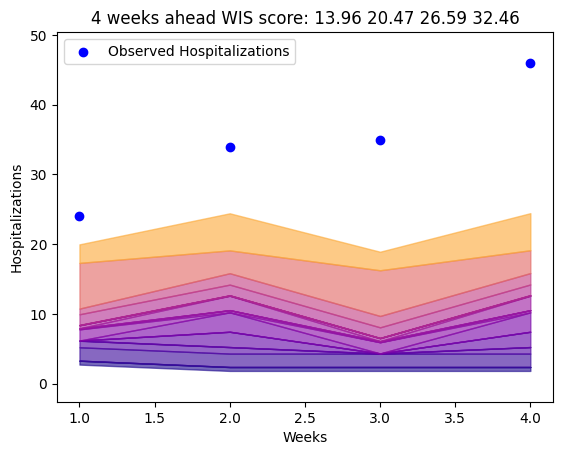

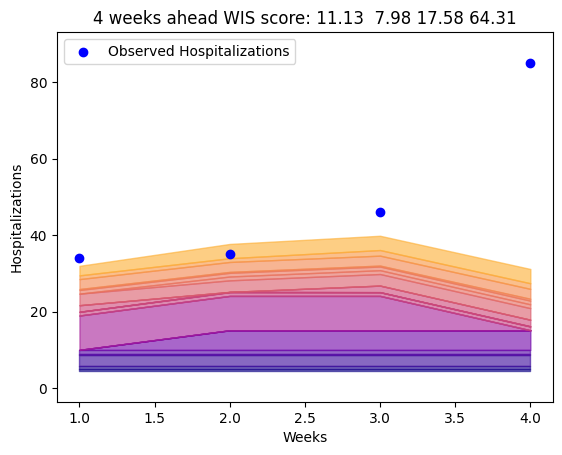

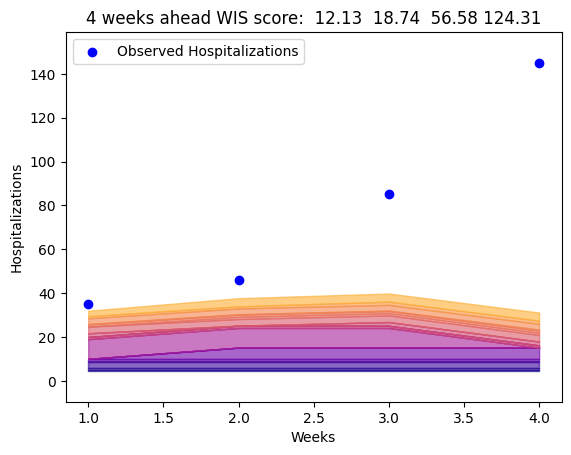

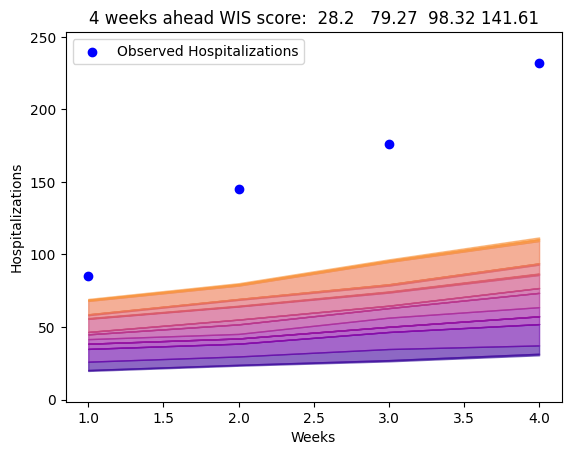

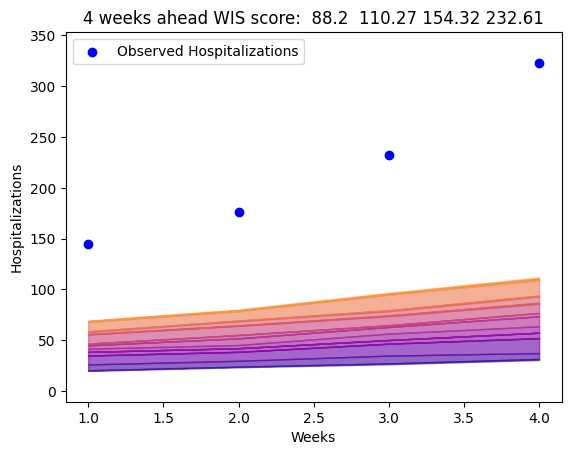

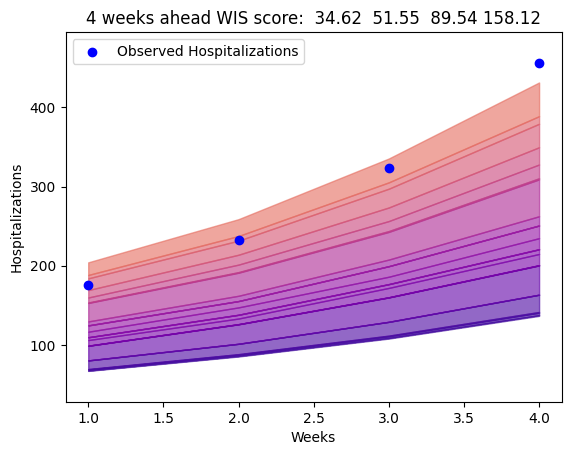

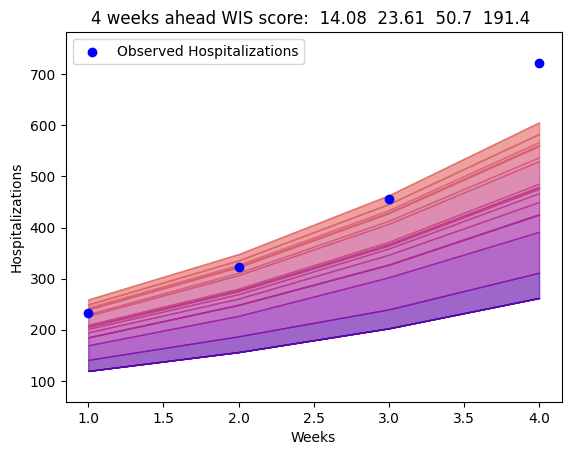

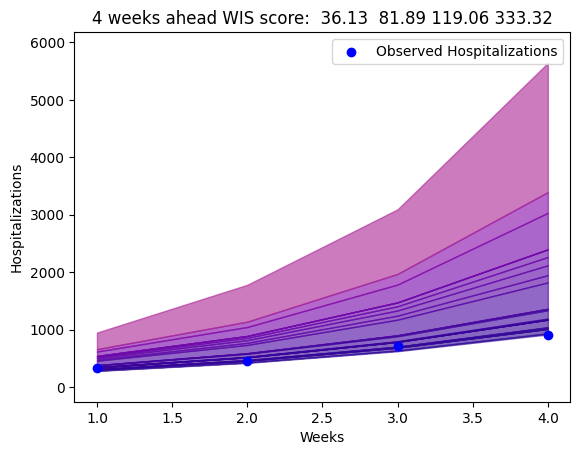

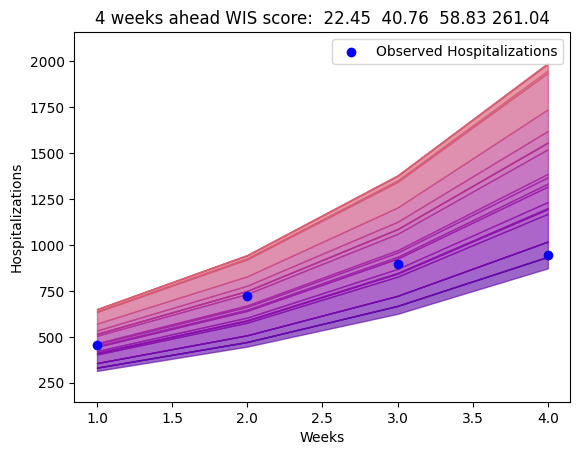

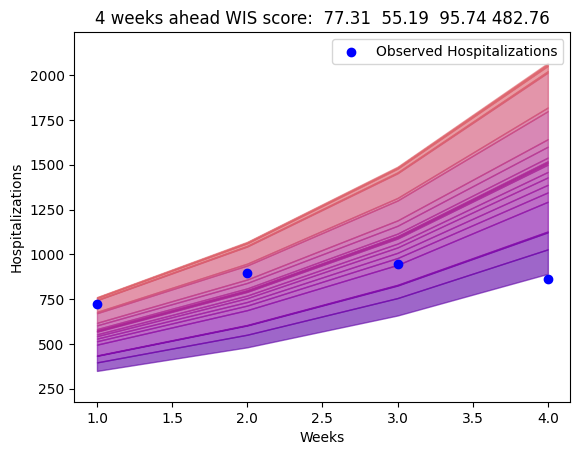

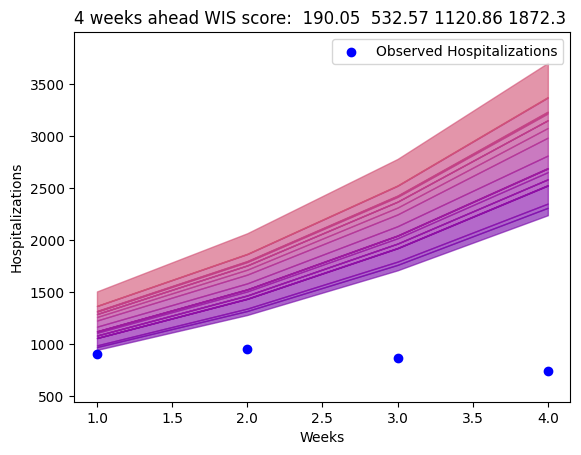

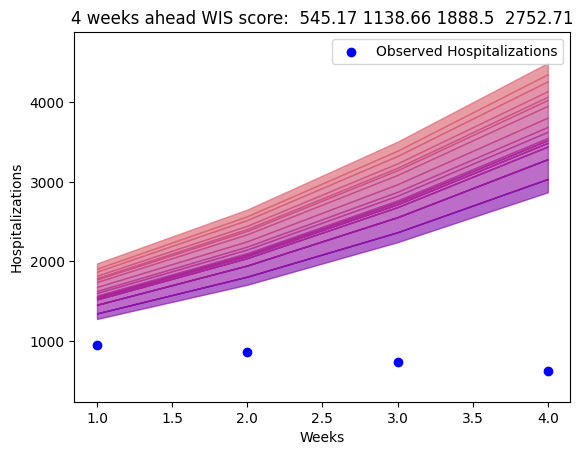

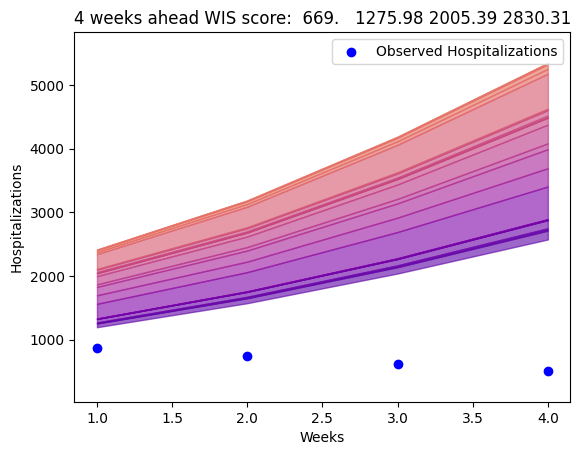

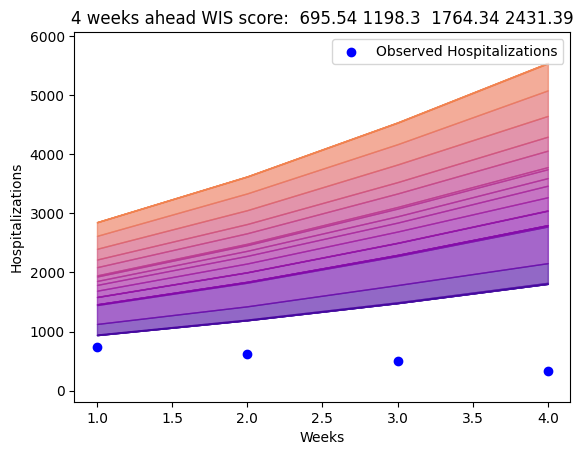

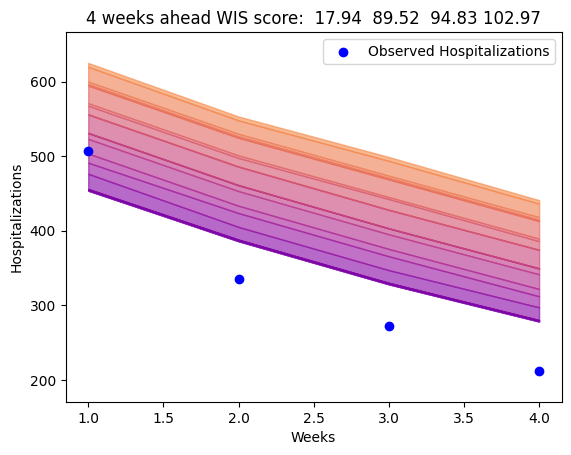

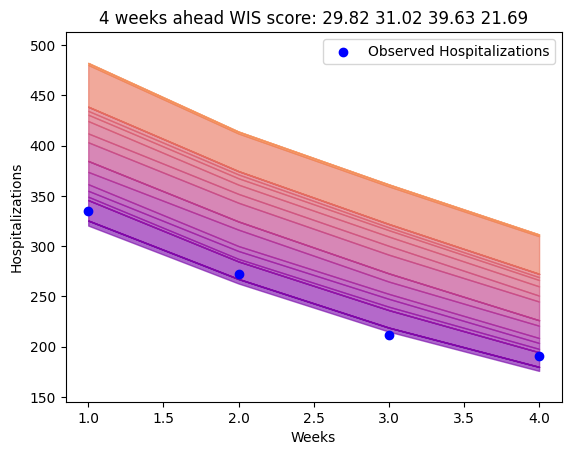

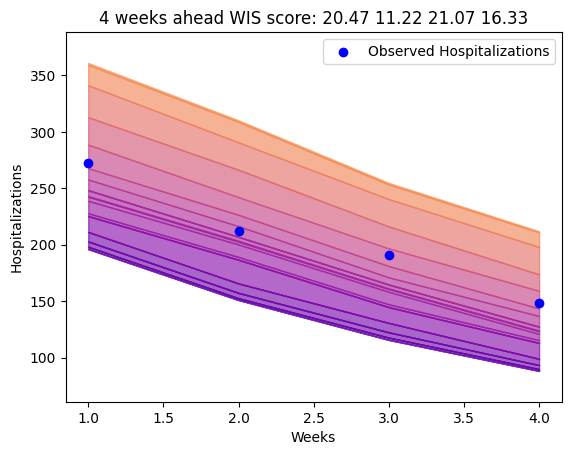

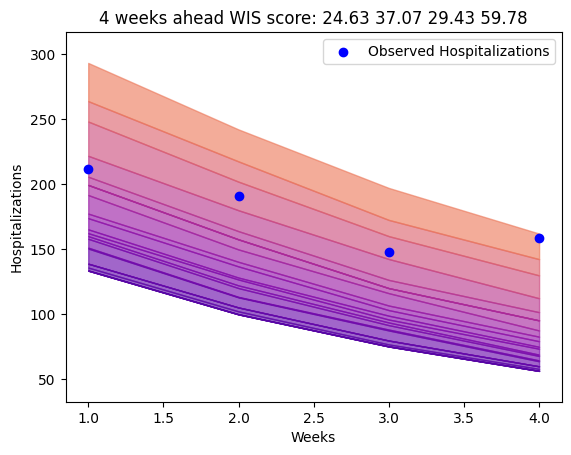

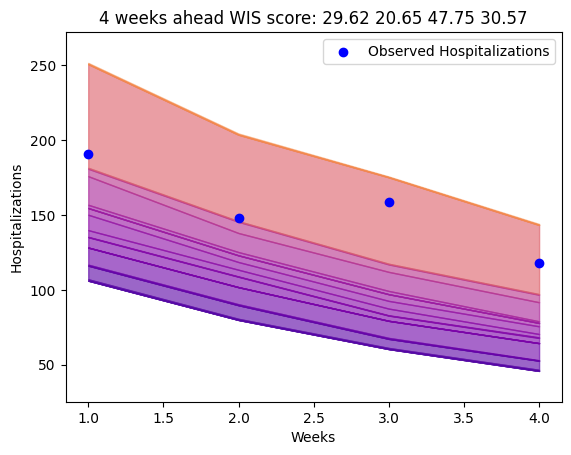

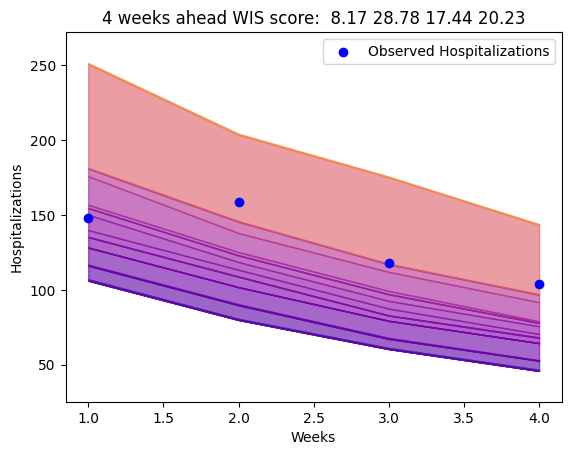

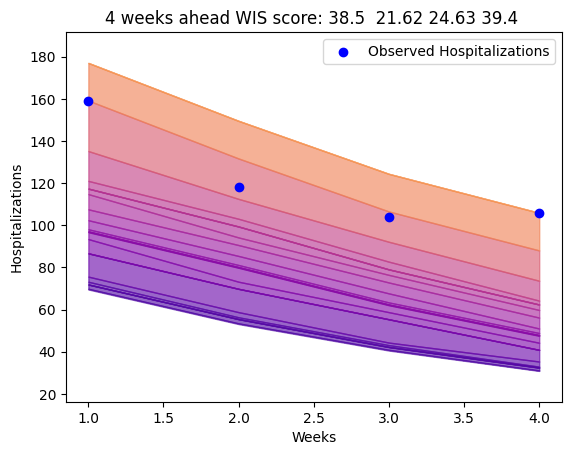

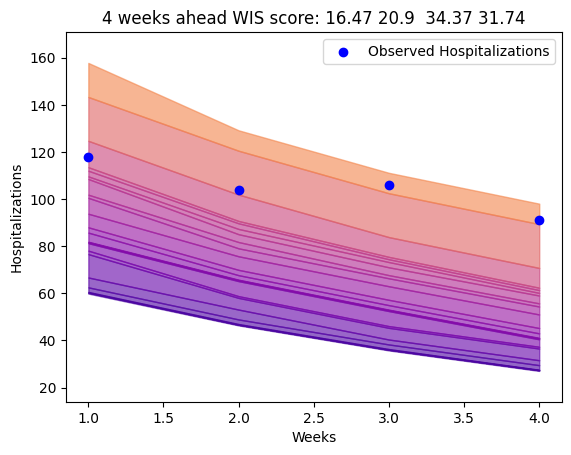

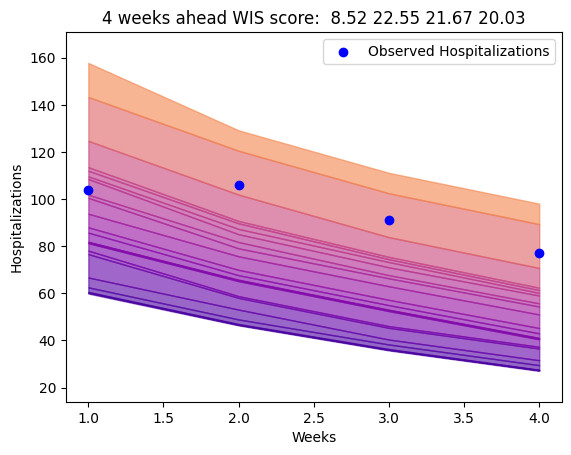

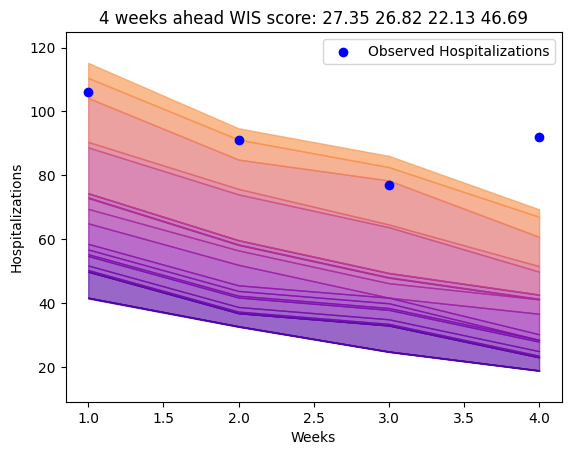

In [18]:
one_state_all_scores(4)